# 👕 PyTorch를 활용한 MobileNetV2 기반 Fashion‑MNIST 전이학습 및 미세조정

TensorFlow 코드(모바일넷V2를 활용한 **Fashion‑MNIST 전이학습 및 미세조정**)를 **PyTorch**로 변환한 예제입니다.

## 📝 진행 순서

1. **Fashion‑MNIST 데이터셋 불러오기** (`torchvision.datasets`)  
2. **데이터 전처리 및 증강** (`torchvision.transforms`)  
   - `resize` 및 **3채널(RGB) 변환**  
   - `IMG_SIZE=64` 유지  
3. **사전학습된 MobileNetV2 활용** (`torchvision.models`)  
   - **기존 분류기 (head) 교체 후 전이학습 진행**  
4. **훈련 과정**  
   - 초기 **15 epoch 학습**  
   - 일부 **feature extractor 층 미세조정 (fine‑tuning)**  
5. **테스트셋 예측 결과 및 학습 곡선 시각화**  

## 🔎 참고사항
- **Fashion‑MNIST**는 원본이 `28×28` **그레이스케일 이미지**이므로, 학습 전에 **resize 및 RGB 변환**을 적용합니다.  
- **MobileNetV2의 기본 입력 크기**는 `224×224`이지만, TF 코드에서 `IMG_SIZE=64`를 사용하므로 그대로 유지합니다.  
  - (⚠️ 실제 전이학습에서는 입력 크기를 크게 하는 것이 일반적으로 더 좋습니다.)
- **PyTorch의 `CrossEntropyLoss`**는 내부적으로 **softmax를 포함**하므로, 마지막 레이어에는 **softmax를 사용하지 않습니다.**  
- **미세조정(fine‑tuning)** 시 **어느 층부터 학습할지**는 `MobileNetV2.feature` 내부의 **블록 인덱스**로 제어합니다.  

# 라이브러리 불러오기

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np

# Device 설정 (GPU 사용 가능하면 GPU 사용)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("사용 device:", device)

사용 device: cuda


In [21]:
# 이미지 크기 및 데이터 증강/전처리 정의
IMG_SIZE = 64
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    # FashionMNIST는 기본 PIL 이미지로 'L' 모드이므로 3채널 RGB로 변환
    transforms.Lambda(lambda x: x.convert("RGB")),
    # RandomAffine로 회전(±10도), 이동(최대 10%) 및 확대/축소(0.9~1.1)
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),  # 수평 뒤집기
    transforms.ToTensor(),  # [0,1] 범위로 스케일링
])
test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.ToTensor(),
])

# FashionMNIST 데이터셋 불러오기 (학습 데이터는 10,000개만 사용)
train_dataset_full = datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)
# 전체 60,000개 중 10,000개만 사용 (OOM 문제 회피)
train_subset = Subset(train_dataset_full, list(range(10000)))

# DataLoader 정의
batch_size = 256
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [22]:
# MobileNetV2 기반 모델 정의 (전이학습 및 새로운 head 추가)
class FashionMobileNetV2(nn.Module):
    def __init__(self):
        super(FashionMobileNetV2, self).__init__()
        # 사전 훈련된 MobileNetV2 불러오기 (분류기 제외)
        self.base = models.mobilenet_v2(pretrained=True)
        # 초기에는 base_model의 파라미터를 동결 (전이학습)
        for param in self.base.parameters():
            param.requires_grad = False

        # 새 분류기: Global Average Pooling 후, dropout, 64 뉴런 fc, ReLU, 최종 fc (10 클래스)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(1280, 64)  # MobileNetV2의 마지막 출력 채널은 1280
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 10)
    
    def forward(self, x):
        # x: (batch, 3, IMG_SIZE, IMG_SIZE)
        x = self.base.features(x)  # Feature 추출
        # Global Average Pooling (spatial 차원을 평균)
        x = x.mean([2, 3])  # 결과: (batch, 1280)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# 모델 생성 및 device로 이동
model = FashionMobileNetV2().to(device)

# 손실 함수 및 optimizer 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

In [23]:
# 학습 및 평가 함수 정의
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [24]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# 1. 전이학습 (Freeze base_model) – 15 에폭

In [25]:
num_epochs = 15
train_losses = []
train_accs = []
val_losses = []
val_accs = []

print("----- 전이학습 시작 -----")
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, test_loader, criterion, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} / Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# 테스트 데이터 평가
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"\n테스트 정확도: {test_acc:.4f}")

----- 전이학습 시작 -----
Epoch 1/15 - Train Loss: 1.3723, Train Acc: 0.5589 / Val Loss: 1.1815, Val Acc: 0.6400
Epoch 2/15 - Train Loss: 0.9149, Train Acc: 0.6892 / Val Loss: 0.7837, Val Acc: 0.7351
Epoch 3/15 - Train Loss: 0.8346, Train Acc: 0.7112 / Val Loss: 0.7654, Val Acc: 0.7407
Epoch 4/15 - Train Loss: 0.8260, Train Acc: 0.7129 / Val Loss: 0.7232, Val Acc: 0.7490
Epoch 5/15 - Train Loss: 0.8185, Train Acc: 0.7152 / Val Loss: 0.7452, Val Acc: 0.7386
Epoch 6/15 - Train Loss: 0.8021, Train Acc: 0.7205 / Val Loss: 0.6757, Val Acc: 0.7600
Epoch 7/15 - Train Loss: 0.7791, Train Acc: 0.7295 / Val Loss: 0.6775, Val Acc: 0.7609
Epoch 8/15 - Train Loss: 0.7651, Train Acc: 0.7316 / Val Loss: 0.6785, Val Acc: 0.7604
Epoch 9/15 - Train Loss: 0.7833, Train Acc: 0.7303 / Val Loss: 0.6676, Val Acc: 0.7663
Epoch 10/15 - Train Loss: 0.7674, Train Acc: 0.7295 / Val Loss: 0.6637, Val Acc: 0.7704
Epoch 11/15 - Train Loss: 0.7745, Train Acc: 0.7315 / Val Loss: 0.6788, Val Acc: 0.7597
Epoch 12/15 - Train L

# 2. 미세조정 (Fine-tuning) 
- base_model의 일부 레이어만 학습하도록 설정 (예: features의 인덱스 10 이후만 학습)

In [26]:
fine_tune_at = 10  # 예시: 앞쪽 10개 레이어는 동결, 나머지는 학습
for i, layer in enumerate(model.base.features):
    if i < fine_tune_at:
        for param in layer.parameters():
            param.requires_grad = False
    else:
        for param in layer.parameters():
            param.requires_grad = True

# 미세조정을 위한 학습률 낮추기
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)

# 미세조정 15 에폭 추가 (총 30 에폭)
fine_tune_epochs = 15
total_epochs = num_epochs + fine_tune_epochs

print("\n----- 미세조정 시작 -----")
for epoch in range(num_epochs, total_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, test_loader, criterion, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}/{total_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} / Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


----- 미세조정 시작 -----
Epoch 16/30 - Train Loss: 0.5816, Train Acc: 0.7895 / Val Loss: 0.4746, Val Acc: 0.8322
Epoch 17/30 - Train Loss: 0.4745, Train Acc: 0.8260 / Val Loss: 0.4330, Val Acc: 0.8429
Epoch 18/30 - Train Loss: 0.4274, Train Acc: 0.8420 / Val Loss: 0.4006, Val Acc: 0.8557
Epoch 19/30 - Train Loss: 0.3922, Train Acc: 0.8555 / Val Loss: 0.3897, Val Acc: 0.8582
Epoch 20/30 - Train Loss: 0.3597, Train Acc: 0.8666 / Val Loss: 0.3668, Val Acc: 0.8672
Epoch 21/30 - Train Loss: 0.3403, Train Acc: 0.8744 / Val Loss: 0.3499, Val Acc: 0.8728
Epoch 22/30 - Train Loss: 0.3275, Train Acc: 0.8780 / Val Loss: 0.3441, Val Acc: 0.8791
Epoch 23/30 - Train Loss: 0.3108, Train Acc: 0.8819 / Val Loss: 0.3356, Val Acc: 0.8811
Epoch 24/30 - Train Loss: 0.3056, Train Acc: 0.8834 / Val Loss: 0.3326, Val Acc: 0.8833
Epoch 25/30 - Train Loss: 0.2944, Train Acc: 0.8875 / Val Loss: 0.3302, Val Acc: 0.8851
Epoch 26/30 - Train Loss: 0.2725, Train Acc: 0.8985 / Val Loss: 0.3334, Val Acc: 0.8818
Epoch 27/30

# 3. 학습 이력 시각화

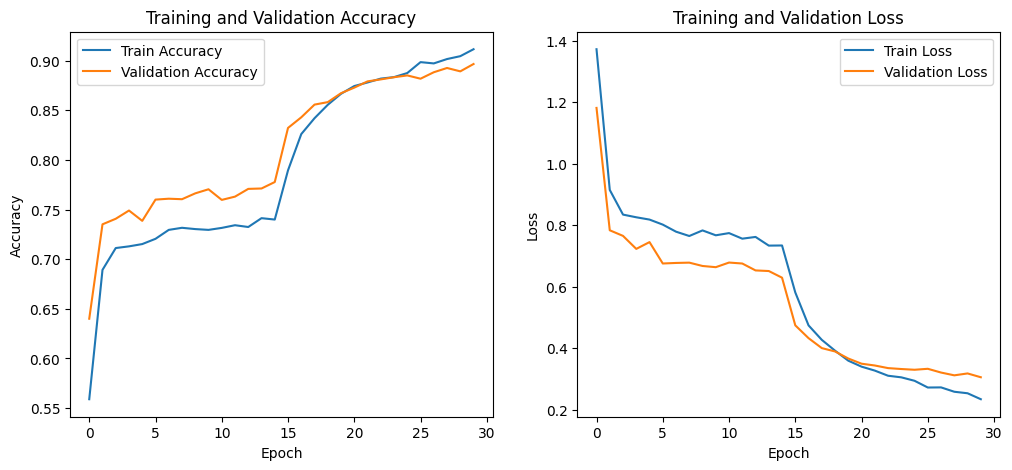

In [27]:
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# 4. 테스트 데이터에 대해 예측하고 결과 시각화

In [28]:
model.eval()
all_preds = []
all_labels = []
all_images = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)
        all_preds.append(probs.cpu())
        all_labels.append(labels)
        all_images.append(inputs.cpu())
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)
all_images = torch.cat(all_images)

In [29]:
# FashionMNIST 클래스 이름
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

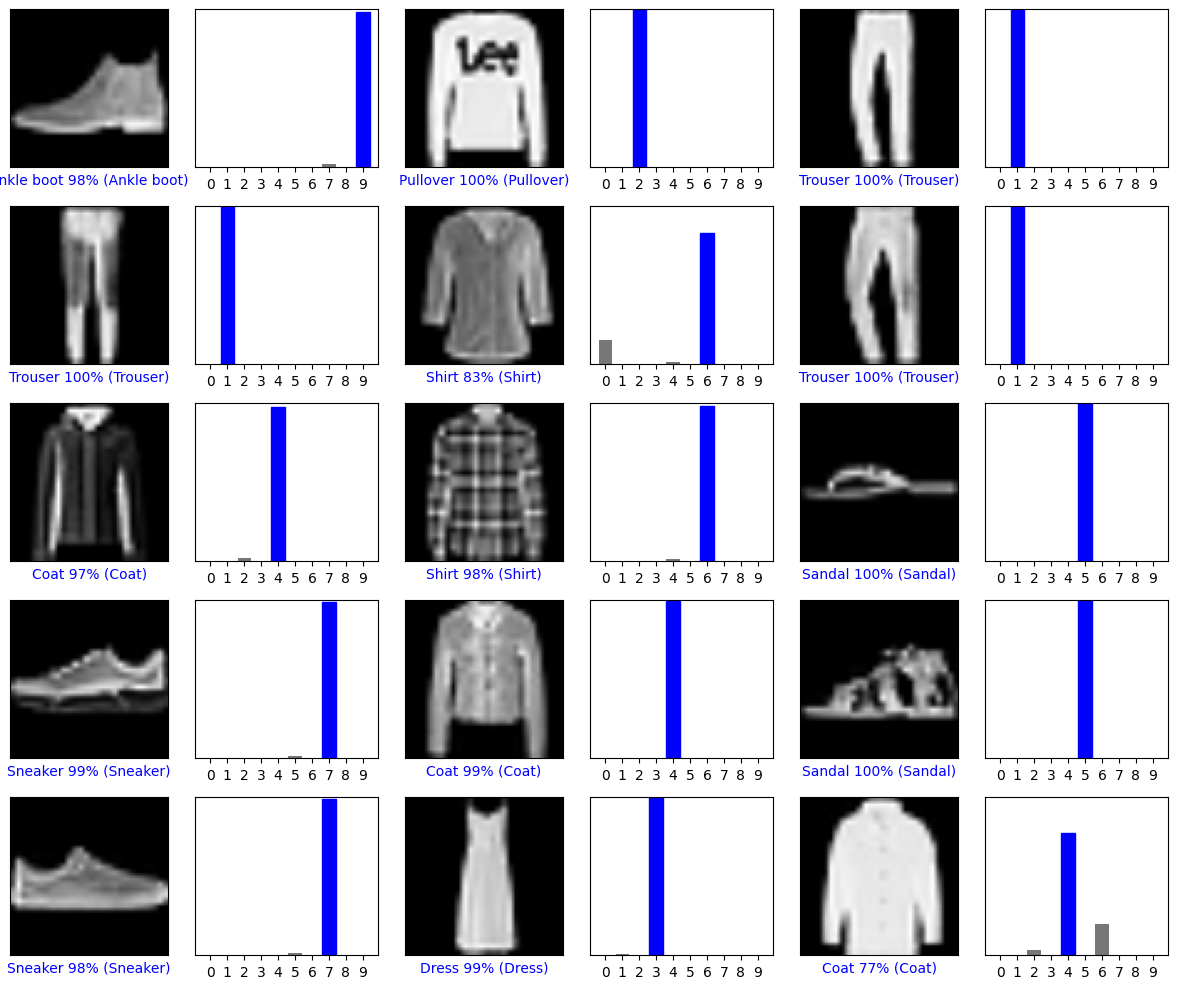

In [30]:
# 예측 결과 시각화를 위한 함수
def plot_image(i, predictions_array, true_label, img):
    predictions_array = predictions_array.numpy()
    true_label = true_label.item() if torch.is_tensor(true_label) else true_label
    # img: (3, H, W) -> (H, W, 3)
    img = img.permute(1, 2, 0).numpy()
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    predicted_label = np.argmax(predictions_array)
    color = 'blue' if predicted_label == true_label else 'red'
    plt.xlabel(f"{class_names[predicted_label]} {100*np.max(predictions_array):2.0f}% ({class_names[true_label]})", color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array = predictions_array.numpy()
    true_label = true_label.item() if torch.is_tensor(true_label) else true_label
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    bars = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    bars[predicted_label].set_color('red')
    bars[true_label].set_color('blue')

# 15개 테스트 이미지에 대해 예측 결과 시각화
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, all_preds[i], all_labels[i], all_images[i])
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    plot_value_array(i, all_preds[i], all_labels[i])
plt.tight_layout()
plt.show()